In [1]:
conda install -c conda-forge shap

Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [107]:
import numpy as np
import pandas as pd
from numpy import sqrt
from numpy import argmax
from sklearn.metrics import precision_recall_curve
from pandas import DataFrame, Series
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, classification_report, recall_score, accuracy_score, precision_score, confusion_matrix
import shap

get_ipython().run_line_magic('matplotlib', 'inline')
shap.initjs()


## Read Input Data

In [108]:
fraud_data = pd.read_csv('data/Fraud_Data.csv')
ip_data = pd.read_csv('data/IpAddress_to_Country.csv')

In [109]:
fraud_data.head(5)

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [110]:
ip_data.head(5)

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


In [111]:
fraud_data.shape, ip_data.shape

((151112, 11), (138846, 3))

In [112]:
fraud_data.dtypes

user_id             int64
signup_time        object
purchase_time      object
purchase_value      int64
device_id          object
source             object
browser            object
sex                object
age                 int64
ip_address        float64
class               int64
dtype: object

In [113]:
ip_data.dtypes

lower_bound_ip_address    float64
upper_bound_ip_address      int64
country                    object
dtype: object

# Getting Country from IP Address

In [114]:
def get_country_from_ip(ip):
    country = ip_data.loc[(ip_data['lower_bound_ip_address'].le(ip)) & (ip_data['upper_bound_ip_address'].ge(ip)), 'country'].values
    
    if country.shape[0]>0:
        return country[0]
    else:
        return 'NA'

fraud_data['country'] = fraud_data.ip_address.map(get_country_from_ip)
fraud_data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NA
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States


## Creating a new csv

In [115]:
fraud_data.to_csv('data.csv')

# Exploratory Data Analysis

In [116]:
dt = pd.read_csv('data.csv')

In [117]:
dt.head(10)

,Unnamed: 0,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NaN
4,4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States
5,5,159135,2015-05-21 06:03:03,2015-07-09 08:05:14,42,ALEYXFXINSXLZ,Ads,Chrome,M,18,2.809315e+09,0,Canada
6,6,50116,2015-08-01 22:40:52,2015-08-27 03:37:57,11,IWKVZHJOCLPUR,Ads,Chrome,F,19,3.987484e+09,0,NaN
7,7,360585,2015-04-06 07:35:45,2015-05-25 17:21:14,27,HPUCUYLMJBYFW,Ads,Opera,M,34,1.692459e+09,0,United States
8,8,159045,2015-04-21 23:38:34,2015-06-02 14:01:54,30,ILXYDOZIHOOHT,SEO,IE,F,43,3.719094e+09,0,China
9,9,182338,2015-01-25 17:49:49,2015-03-23 23:05:42,62,NRFFPPHZYFUVC,Ads,IE,M,31,3.416747e+08,0,United States


In [118]:
dt = dt.drop('Unnamed: 0', axis = 1)

In [119]:
dt.dtypes

user_id             int64
signup_time        object
purchase_time      object
purchase_value      int64
device_id          object
source             object
browser            object
sex                object
age                 int64
ip_address        float64
class               int64
country            object
dtype: object

In [120]:
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 12 columns):
user_id           151112 non-null int64
signup_time       151112 non-null object
purchase_time     151112 non-null object
purchase_value    151112 non-null int64
device_id         151112 non-null object
source            151112 non-null object
browser           151112 non-null object
sex               151112 non-null object
age               151112 non-null int64
ip_address        151112 non-null float64
class             151112 non-null int64
country           129146 non-null object
dtypes: float64(1), int64(4), object(7)
memory usage: 13.8+ MB


In [121]:
dt.isnull().sum()

user_id               0
signup_time           0
purchase_time         0
purchase_value        0
device_id             0
source                0
browser               0
sex                   0
age                   0
ip_address            0
class                 0
country           21966
dtype: int64

In [122]:
dt['country'] = dt['country'].fillna('NA')

In [123]:
dt.describe()

,user_id,purchase_value,age,ip_address,class
count,151112.000000,151112.000000,151112.000000,1.511120e+05,151112.000000
mean,200171.040970,36.935372,33.140704,2.152145e+09,0.093646
std,115369.285024,18.322762,8.617733,1.248497e+09,0.291336
min,2.000000,9.000000,18.000000,5.209350e+04,0.000000
25%,100642.500000,22.000000,27.000000,1.085934e+09,0.000000
50%,199958.000000,35.000000,33.000000,2.154770e+09,0.000000
75%,300054.000000,49.000000,39.000000,3.243258e+09,0.000000
max,400000.000000,154.000000,76.000000,4.294850e+09,1.000000


Average purchase value is 36.93, while maximum is 154 and minimum is 9. 

For age, average is 33, min is 18 and max is 76.

In [124]:
dt.describe(include=['object']).T

,count,unique,top,freq
signup_time,151112,151112,2015-02-26 15:27:26,1
purchase_time,151112,150679,2015-07-17 23:22:55,3
device_id,151112,137956,CQTUVBYIWWWBC,20
source,151112,3,SEO,60615
browser,151112,5,Chrome,61432
sex,151112,2,M,88293
country,151112,182,United States,58049


Out of 182 countries, maximum (more than 30%) are from USA. 

In [125]:
dt.nunique()

user_id           151112
signup_time       151112
purchase_time     150679
purchase_value       122
device_id         137956
source                 3
browser                5
sex                    2
age                   58
ip_address        143512
class                  2
country              182
dtype: int64

In [126]:
dt['class'].value_counts()

0    136961
1     14151
Name: class, dtype: int64

# Data Visualization

### Class Variables

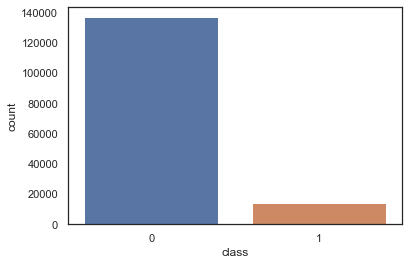

In [127]:
sns.countplot(data = dt, x = "class");

The class distribution is imbalanced. About 90% labels are class 0 i.e. non-fraudulent where only about 10% labels are fraud.

## Relationship between class and different attributes

### a) Numerical Attributes

/Users/Anurag/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/Anurag/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


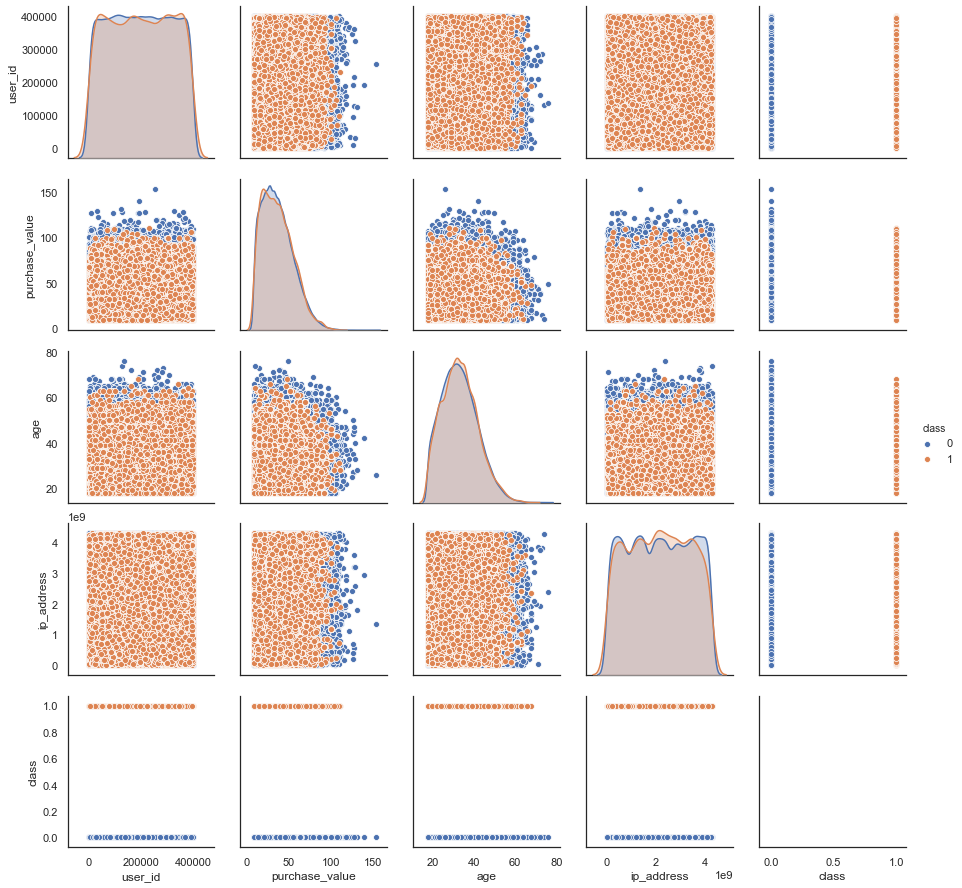

In [128]:
sns.pairplot(dt, hue='class');

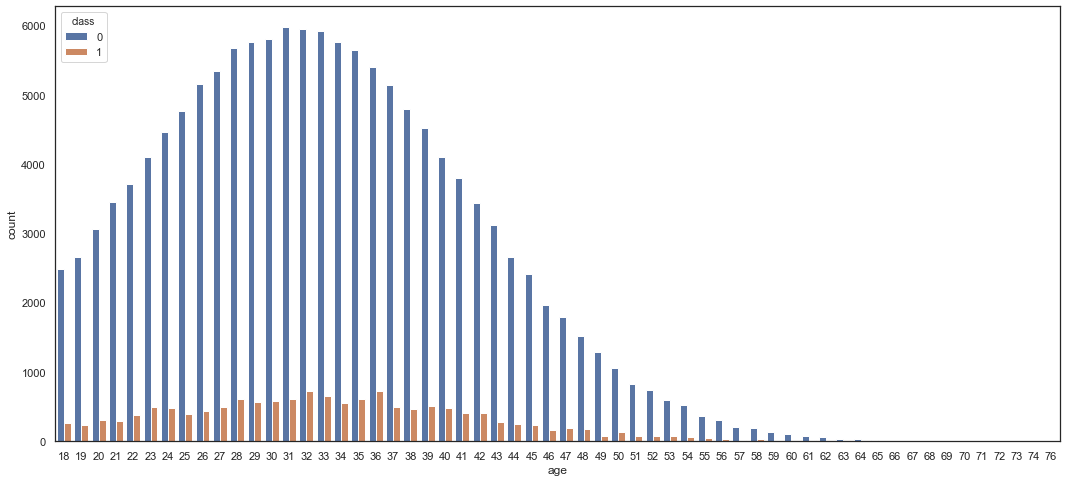

In [129]:
fig, ax = plt.subplots(figsize=(18,8))
sns.countplot(x='age', hue='class', data= dt, ax = ax);

### b) Categorical Attributes

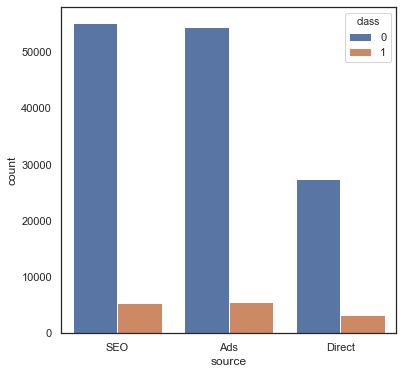

In [130]:
fig, ax = plt.subplots(figsize=(6,6))
sns.countplot(x='source', hue='class', data = dt, ax=ax);

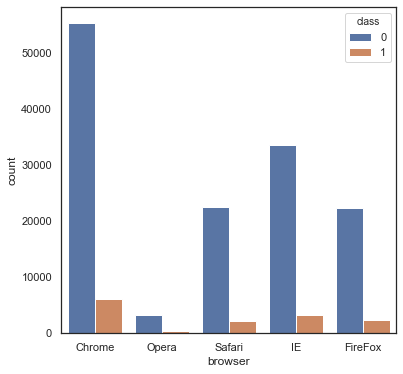

In [131]:
fig, ax = plt.subplots(figsize=(6,6))
sns.countplot(x='browser', hue='class', data = dt, ax=ax);

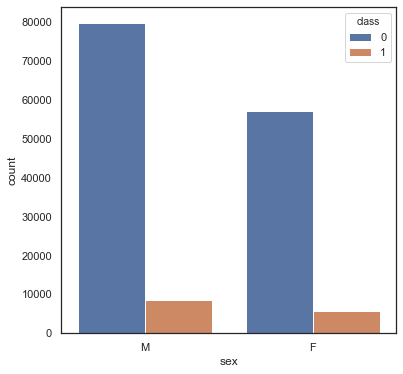

In [132]:
fig, ax = plt.subplots(figsize=(6,6))
sns.countplot(x='sex', hue='class', data = dt, ax=ax);

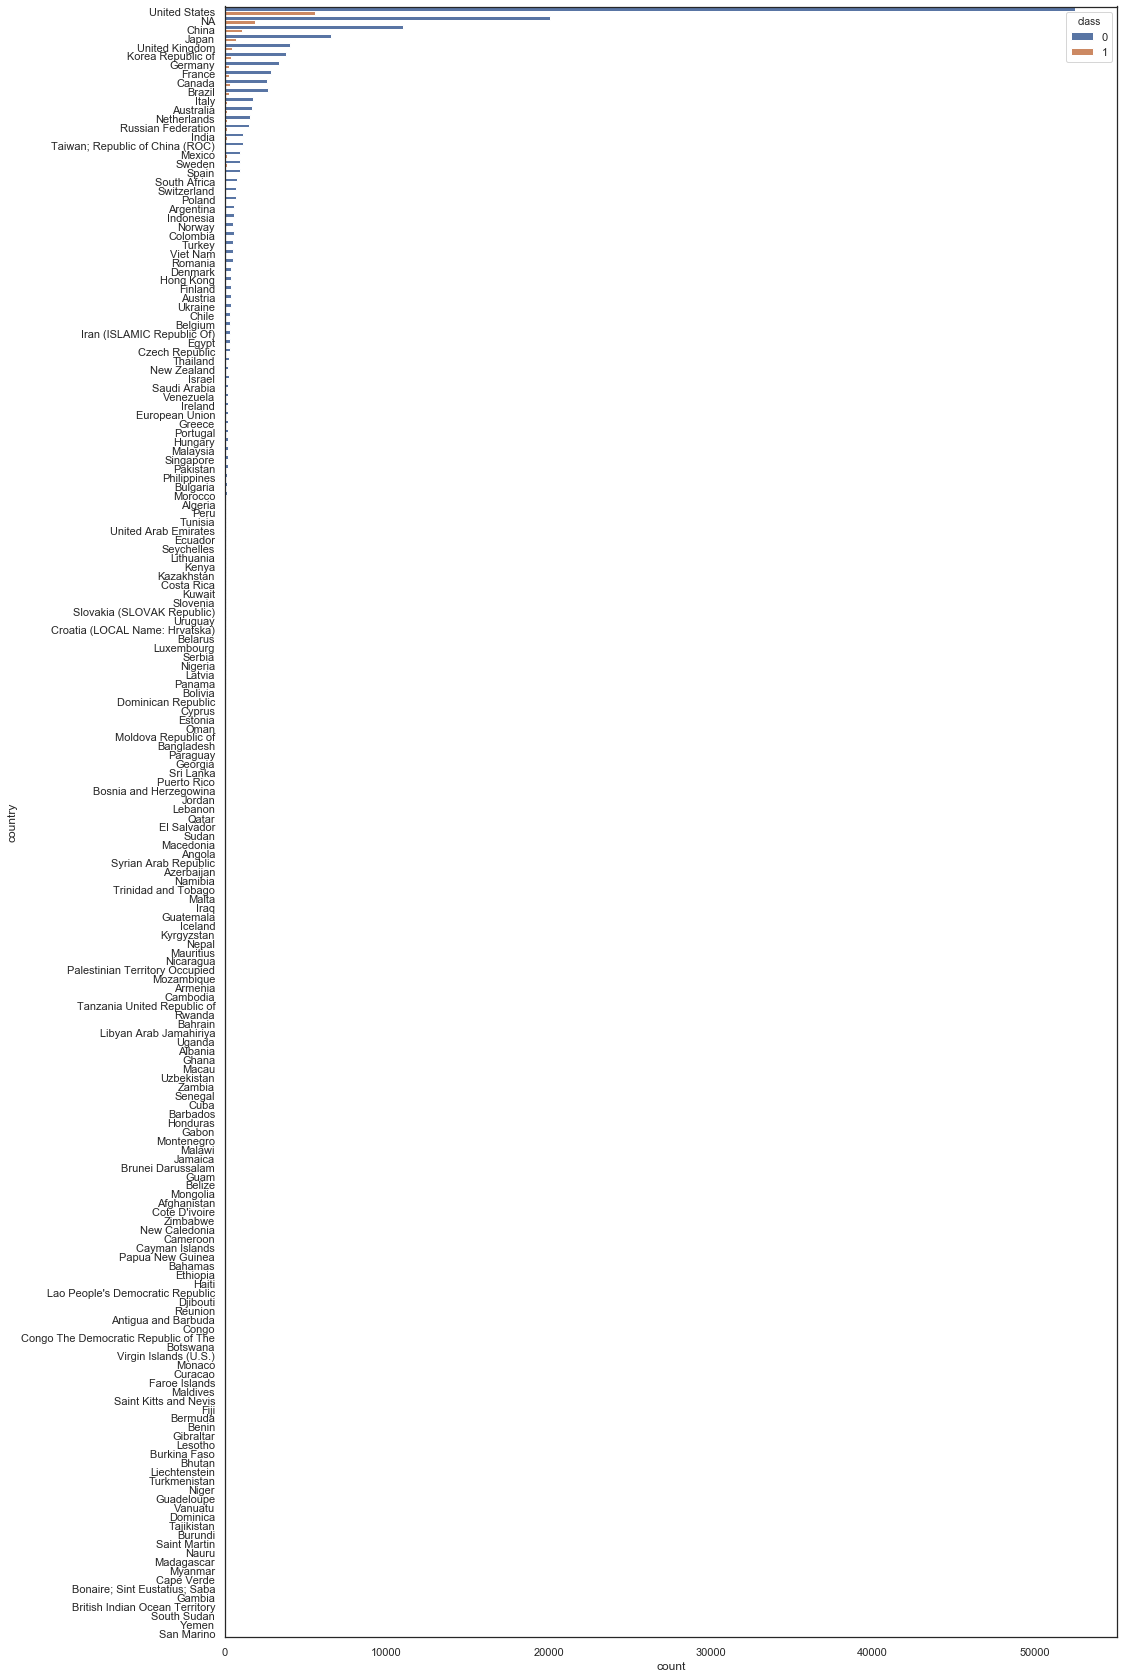

In [210]:
fig, ax = plt.subplots(figsize=(16,30))
sns.countplot(y='country', hue='class', data = dt, ax=ax, order=dt['country'].value_counts().sort_values(ascending=False).index);

# Feature Engineering

### Selecting Top Countries

Experiments with selecting few top countries (50,20,10) by value counts, revealed that it didn't provide any noting improvement in the classifier. And since information loss is taking place by clubbing many countries with small value count into a single category "Others", it is decided not to do any feature engineering with country column.

In [134]:
# country_frame = pd.DataFrame(dt['country'].value_counts())
# country_frame.head(10)

In [135]:
# country_frame = country_frame.iloc[0:51]
# top_countries = country_frame.index.tolist()
# top_countries.pop(1)
# top_countries

In [136]:
# def change_country_name(c):
#     if c in top_countries:
#         return c
#     else:
#         return 'Others'
# dt['country'] = dt['country'].apply(change_country_name)

In [137]:
# dt.head()

In [138]:
# dt['country'].value_counts()

### Time Difference between SignUp Time and Purchase Time

In [139]:
dt['signup_time'] = pd.to_datetime(dt['signup_time'])
dt['purchase_time'] = pd.to_datetime(dt['purchase_time'])

In [140]:
dt['time_diff'] = (dt['purchase_time'] - dt['signup_time']).astype('timedelta64[m]')

In [141]:
dt.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,time_diff
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,75111.0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,299.0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,0.0
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NA,8201.0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,72691.0


### Counting different User Ids using the same device

In [142]:
device_count = len(dt) * [0]
device = dt.groupby('device_id')['user_id'].count()
device_count = device[dt['device_id']]
device_count = device_count.reset_index().drop('device_id', axis = 1)
device_count.columns = ['device_count']

In [143]:
dt = pd.concat([dt, device_count], axis = 1)

In [144]:
dt.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,time_diff,device_count
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,75111.0,1
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,299.0,1
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,0.0,12
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NA,8201.0,1
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,72691.0,1


### Counting number of User Ids using the same IP Address

In [145]:
ip_count = dt.groupby('ip_address')['user_id'].count()
ip_count = ip_count[dt['ip_address']].reset_index().drop('ip_address', axis = 1)
ip_count.columns = ['ip_count']
dt = pd.concat([dt, ip_count], axis = 1)

In [146]:
dt.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,time_diff,device_count,ip_count
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,75111.0,1,1
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,299.0,1,1
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,0.0,12,12
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NA,8201.0,1,1
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,72691.0,1,1


In [147]:
dt = dt.drop(['user_id', 'signup_time','purchase_time','device_id','ip_address'], axis = 1)
dt.head()

,purchase_value,source,browser,sex,age,class,country,time_diff,device_count,ip_count
0,34,SEO,Chrome,M,39,0,Japan,75111.0,1,1
1,16,Ads,Chrome,F,53,0,United States,299.0,1,1
2,15,SEO,Opera,M,53,1,United States,0.0,12,12
3,44,SEO,Safari,M,41,0,NA,8201.0,1,1
4,39,Ads,Safari,M,45,0,United States,72691.0,1,1


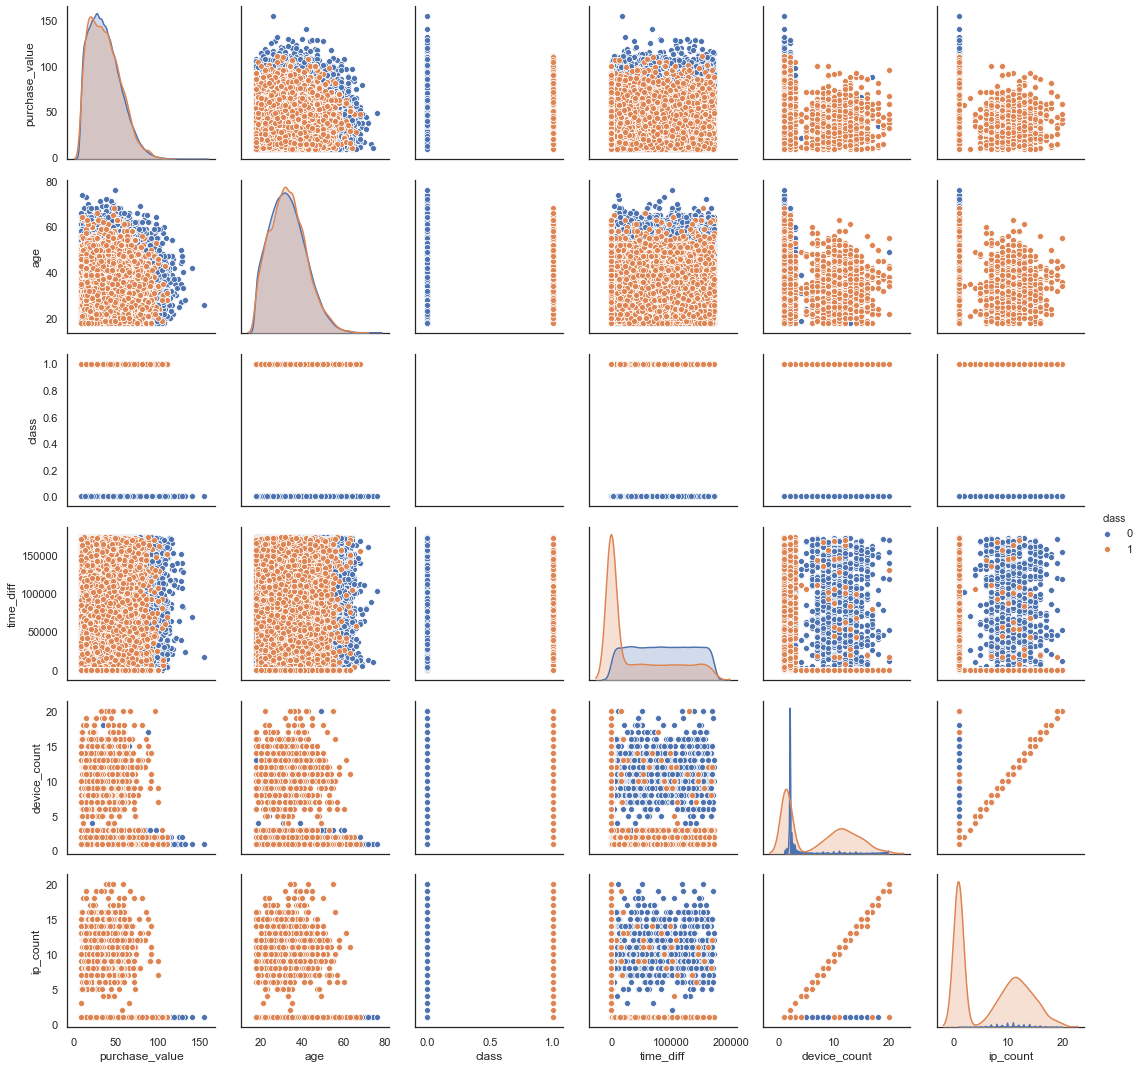

In [148]:
sns.pairplot(dt, hue='class');

# Feature Transformation

## Label Encoding 

In [149]:
categorical = ['source','browser', 'sex', 'country']
label_encoder = LabelEncoder()
for column in categorical:
    label_encoder.fit(dt[column])
    dt[column] = label_encoder.transform(dt[column])

One-hot encoding of 'source', 'browser' and 'sex' column was also tried to see if it gives better results, but was later dropped as data from feature importance score showed that classifier gave siginificantly minute importance to the newly created encodings. As such it didn't favour much to unnecessarily increase the dimensions.

### Correlation of attributes with the class

In [150]:
column_list = list(dt.columns)
column_list.remove('class')
for col in column_list:
    print(col, 'correlation with class is:', dt[col].corr(dt['class']))

purchase_value correlation with class is: 0.0010110350071608383
source correlation with class is: -0.004317690600814203
browser correlation with class is: -0.013494104113984929
sex correlation with class is: 0.007638522354386908
age correlation with class is: 0.006623570733961866
country correlation with class is: 0.00303700083434717
time_diff correlation with class is: -0.25788662659732736
device_count correlation with class is: 0.6708372831841094
ip_count correlation with class is: 0.6586248216625243


# Model Evaluation

In [151]:
X = dt.drop(['class'], axis=1)
y = dt['class']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

## Random Forest Classifier

Initially, Random Forest Classifier is trained with 5-fold cross validation and a set of few hyperparameters on the training set. After hyperparameter tuning, the best selected model will be used on the test set.

Ideally, the goal was to train the classifier on a much larger set of hyperparameters (similar to the one that has been commented in the code cell) using 5-fold cross validation and then choose the best estimator to build the model. However, given the constraint of time, only few hyperparamaters have been selected to choose from.

In [152]:
# param_grid = {
#     'oob_score': [True],
#     'criterion' : ['entropy'],
#     'max_depth': [10,20,30,40,50],
#     'max_features': [2, 3],
#     'min_samples_leaf': [3, 4, 5,6],
#     'min_samples_split': [3,4,5,6],
#     'n_estimators': [100,150,200,250,300]
# }

param_grid = {
    'oob_score': [True],
    'criterion' : ['entropy', 'gini'],
    'max_depth': [50,10],
    'max_features': [2, 3],
    'min_samples_leaf': [3,4],
    'min_samples_split': [3,4],
    'n_estimators': [100,20]
}

clf = RandomForestClassifier()

clf_grid = GridSearchCV(clf, param_grid, cv=5, n_jobs=-1, verbose=True)


clf_grid.fit(X_train,y_train)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 16.4min
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed: 26.0min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [153]:
print('Best set of parameters are: \n', clf_grid.best_params_)

Best set of parameters are: 
 {'criterion': 'entropy', 'max_depth': 50, 'max_features': 2, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 100, 'oob_score': True}


After hyperparameter tuning, it was found that hyperparameter values that works best for our classification task are:

Criterion: Entropy

Max_depth: 50

Max_features: 2

Min_samples_leaf: 4

Min_samples_Split: 4

n_estimators: 100

In [154]:
best_grid = clf_grid.best_estimator_
preds = best_grid.predict(X_test)
preds_prob = best_grid.predict_proba(X_test)[:, 1]


train_preds = best_grid.predict(X_train)
train_preds_prob = best_grid.predict_proba(X_train)[:, 1]

roc_auc_score_val = roc_auc_score(y_train, train_preds)
f1_score_val = f1_score(y_train, train_preds)
precision = precision_score(y_train, train_preds)
recall = recall_score(y_train, train_preds)
print("Train set results: ",roc_auc_score_val,f1_score_val,precision)
print("F1 Score: ",f1_score_val)
print("Precision: ",precision)
print("Recall Score: ",recall)
print ('ROC AUC Score: ',roc_auc_score_val)

roc_auc_score_val = roc_auc_score(y_test, preds)
f1_score_val = f1_score(y_test, preds)
precision = precision_score(y_test, preds)
recall = recall_score(y_test, preds)
print ("Test set results:")
print("F1 Score: ",f1_score(y_test, preds))
print("Precision: ",precision_score(y_test, preds))
print("Recall Score: ",recall_score(y_test, preds))
print ('Accuracy: ',accuracy_score(y_test, preds))
print(confusion_matrix(y_test, preds))

Train set results:  0.7749910273554579 0.709629713895683 0.9998397179035102
F1 Score:  0.709629713895683
Precision:  0.9998397179035102
Recall Score:  0.5499911832128372
ROC AUC Score:  0.7749910273554579
Test set results:
F1 Score:  0.6930232558139535
Precision:  0.9993293091884641
Recall Score:  0.530437878248487
Accuracy:  0.9563246534096549
[[27413     1]
 [ 1319  1490]]


### Feature Importance Scores

In [155]:
best_grid.feature_importances_

array([0.08351807, 0.0084866 , 0.01426877, 0.00508206, 0.07099886,
       0.047508  , 0.34892914, 0.27482521, 0.1463833 ])

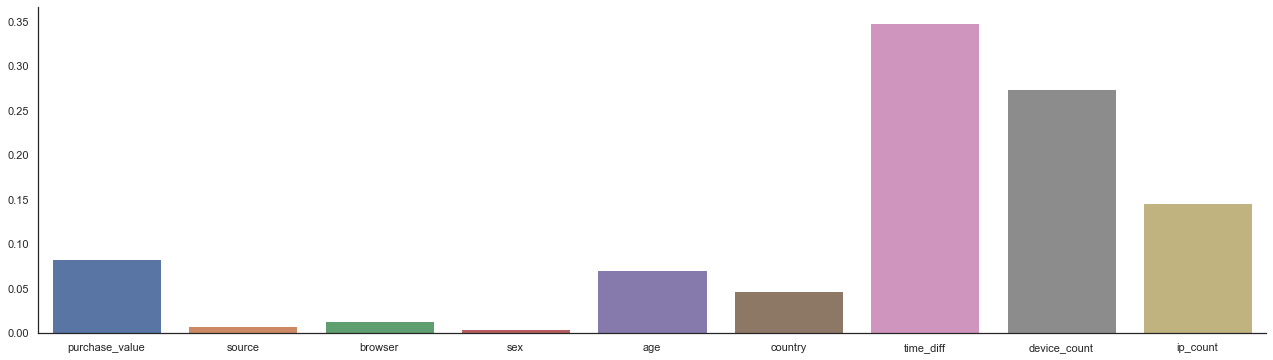

In [156]:
plt.figure(figsize=(22,6))
sns.set(style='white')
ax = sns.barplot(x = X.columns, y = best_grid.feature_importances_)
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.grid(False)

Time difference, device count and Ip count are the top 3 features that classifier found more important than other is predicting the class.

## Threshold Optimization

As this classification task suffers from class imbalance problem, the default threshold can result in poor performance. As such to improve the performance of a classifier we tune the threshold used to map probabilities to class labels.

We experimented with finding optimal thresholds for ROC Curve and Precision-Recall Curve.

### Optimal Threshold for ROC 

In ROC Curve optimal threshold balances between false positive (Specificity) and true positive (Sensitivity) rates. The Geometric Mean or G-Mean is the metric we will optimize to seek a balance between the sensitivity and the specificity.

In [216]:
prob_score = best_grid.predict_proba(X_test)
prob_score = DataFrame(prob_score).iloc[:,1]

In [158]:
fpr,tpr,thresholds = roc_curve(y_test, prob_score)

Best Threshold=0.104891, G-Mean=0.812


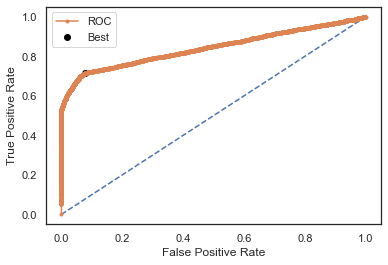

In [159]:
gmeans = sqrt(tpr * (1-fpr))
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

plt.plot([0,1], [0,1], linestyle='--')
plt.plot(fpr, tpr, marker='.', label='ROC')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [211]:
prob = best_grid.predict_proba(X_test)[:,1]
prob_score = DataFrame(prob)
prob[prob > 0.1] = 1
prob[prob <= 0.1] = 0

In [212]:
print(classification_report(y_test, prob))

              precision    recall  f1-score   support

           0       0.97      0.92      0.94     27414
           1       0.48      0.72      0.57      2809

    accuracy                           0.90     30223
   macro avg       0.72      0.82      0.76     30223
weighted avg       0.92      0.90      0.91     30223



Results from thresholding with optimal value obtained using ROC Curve:

Recall of our classifier improved from 0.53 to 0.72 after thresholding with probability value 0.085, however, at the expense of precision which dropped from .999 to 0.48.

### Optimal Threshold for Precision-Recall Curve
Unlike the ROC Curve, a precision-recall curve focuses on the performance of a classifier on the positive (minority class) only. 
Now since we want to optimize threshold that results in the best balance of precision and recall, then this is the same as optimizing the F-measure that summarizes the harmonic mean of both measures. However, here, as we want recall to weigh more than precision, we will optimize F-beta score.

Best Threshold=0.131257, F-beta-Score=0.659


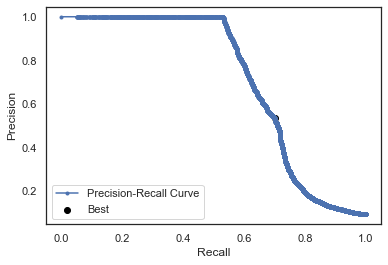

In [162]:
precision, recall, thresholds = precision_recall_curve(y_test, prob_score)
beta = 2
f_beta_score = ((1 + beta ** 2) * (precision * recall)) / (((beta ** 2) * precision) + recall)
ix = argmax(f_beta_score)

print('Best Threshold=%f, F-beta-Score=%.3f' % (thresholds[ix], f_beta_score[ix]))

plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

In [192]:
prob = best_grid.predict_proba(X_test)[:,1]
prob[prob > 0.13] = 1
prob[prob <= 0.13] = 0

In [193]:
print(classification_report(y_test, prob))

              precision    recall  f1-score   support

           0       0.97      0.94      0.95     27414
           1       0.53      0.70      0.60      2809

    accuracy                           0.91     30223
   macro avg       0.75      0.82      0.78     30223
weighted avg       0.93      0.91      0.92     30223



Results from thresholding with optimal value obtained using Precision-Recall Curve:

Recall of our classifier improved from 0.53 to 0.70 after thresholding with probability value 0.154, however, at the expense of precision which dropped from 0.999 to 0.53. F-beta score caluclations with these precision and recall values and beta = 2, turns out to be 88.2 for class 1.

## Gradient Boosting Classifier

Now, Gradient Boosting Classifier is trained with 5-fold cross validation and a set of few hyperparameters on the training set. After hyperparameter tuning, the best selected model will be used on the test set.

Similar to the Random forest classifier, the goal was to train the classifier on a much larger set of hyperparameters using 5-fold cross validation and then choose the best estimator to build the model. However, given the constraint of time, only few hyperparamaters have been selected to choose from.

In [165]:
params = {'n_estimators': [100], 'max_depth': [10], 'subsample': [1.0, 0.5],
          'learning_rate': [0.1, 0.03], 'min_samples_leaf': [5], 'random_state': [42]}

gbc = GradientBoostingClassifier()

gbc_grid = GridSearchCV(gbc, params, cv=5, n_jobs=-1, verbose=True)

gbc_grid.fit(X_train,y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 10.8min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no...
                                                  presort='auto',
  

In [166]:
print('Best set of parameters are: \n', gbc_grid.best_params_)

Best set of parameters are: 
 {'learning_rate': 0.03, 'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 100, 'random_state': 42, 'subsample': 0.5}


Among the given hyperparameters, learning rate = 0.03 and subsample = 0.5, turned out to give best performance for Gradient Boost.

In [167]:
top_grid = gbc_grid.best_estimator_
preds = top_grid.predict(X_test)
preds_prob = top_grid.predict_proba(X_test)[:, 1]


train_preds = top_grid.predict(X_train)
train_preds_prob = top_grid.predict_proba(X_train)[:, 1]

roc_auc_score_val = roc_auc_score(y_train, train_preds)
f1_score_val = f1_score(y_train, train_preds)
precision = precision_score(y_train, train_preds)
recall = recall_score(y_train, train_preds)
print("Train set results: ",roc_auc_score_val,f1_score_val,precision)
print("F1 Score: ",f1_score_val)
print("Precision: ",precision)
print("Recall Score: ",recall)
print ('ROC AUC Score: ',roc_auc_score_val)

roc_auc_score_val = roc_auc_score(y_test, preds)
f1_score_val = f1_score(y_test, preds)
precision = precision_score(y_test, preds)
recall = recall_score(y_test, preds)
print ("Test set results:")
print("F1 Score: ",f1_score(y_test, preds))
print("Precision: ",precision_score(y_test, preds))
print("Recall Score: ",recall_score(y_test, preds))
print ('Accuracy: ',accuracy_score(y_test, preds))
print(confusion_matrix(y_test, preds))

Train set results:  0.7756431578907431 0.7106489373792476 0.9995204603580563
F1 Score:  0.7106489373792476
Precision:  0.9995204603580563
Recall Score:  0.5513137012872509
ROC AUC Score:  0.7756431578907431
Test set results:
F1 Score:  0.6925220622387366
Precision:  0.9959919839679359
Recall Score:  0.5307938768244927
Accuracy:  0.9561923038745327
[[27408     6]
 [ 1318  1491]]


## Feature Importance

In [168]:
top_grid.feature_importances_

array([0.02539991, 0.00735335, 0.00706344, 0.00286643, 0.01953261,
       0.01574097, 0.87054922, 0.05045647, 0.0010376 ])

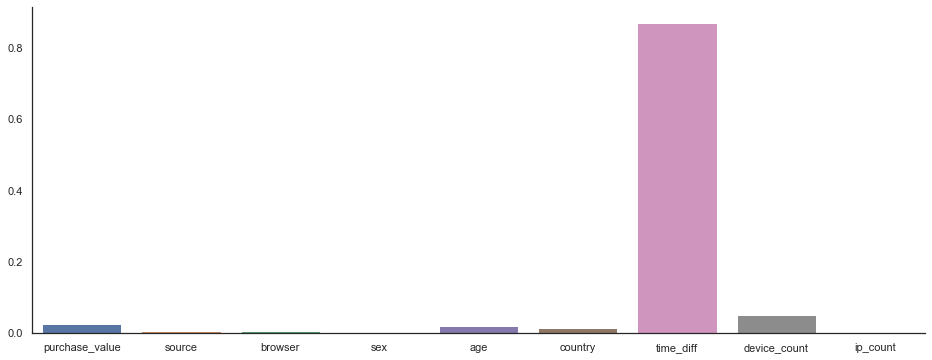

In [169]:
plt.figure(figsize=(16,6))
sns.set(style='white')
ax = sns.barplot(x = X.columns, y = top_grid.feature_importances_)
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.grid(False)

Time difference column has unexceptionally high feature importance for gradient boosting classifier in determining the class. Features such as device count, ip count and purchase value, which were found important for Random forest classifier have very low scores for gradient boost, as compared to time difference feature.

## Threshold Optimization

In [170]:
prob_scores = top_grid.predict_proba(X_test)
prob_scores = DataFrame(prob_scores).iloc[:,1]

### Optimal Threshold for ROC 

In [171]:
fpr,tpr,thresholds = roc_curve(y_test, prob_scores)

Best Threshold=0.090381, G-Mean=0.815


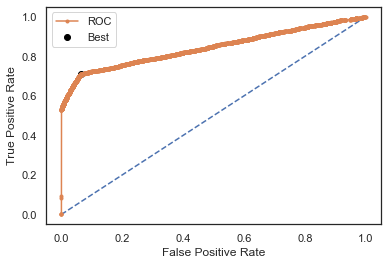

In [172]:
gmeans = sqrt(tpr * (1-fpr))
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

plt.plot([0,1], [0,1], linestyle='--')
plt.plot(fpr, tpr, marker='.', label='ROC')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [194]:
prob = top_grid.predict_proba(X_test)[:,1]
prob[prob > 0.09] = 1
prob[prob <= 0.09] = 0

In [195]:
print(classification_report(y_test, prob))

              precision    recall  f1-score   support

           0       0.97      0.94      0.95     27414
           1       0.53      0.71      0.61      2809

    accuracy                           0.92     30223
   macro avg       0.75      0.82      0.78     30223
weighted avg       0.93      0.92      0.92     30223



Results from thresholding with optimal value obtained using ROC Curve:

Recall of our classifier improved from 0.53 to 0.71 after thresholding with probability value 0.085, however, at the expense of precision which dropped from 0.99 to 0.53.

### Optimal Threshold for Precision-Recall Curve

Best Threshold=0.120382, F-beta-Score=0.666


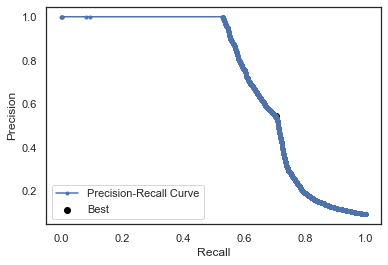

In [175]:
precision, recall, thresholds = precision_recall_curve(y_test, prob_scores)
beta = 2
f_beta_score = ((1 + beta ** 2) * (precision * recall)) / (((beta ** 2) * precision) + recall)
ix = argmax(f_beta_score)

print('Best Threshold=%f, F-beta-Score=%.3f' % (thresholds[ix], f_beta_score[ix]))

plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

In [196]:
prob = top_grid.predict_proba(X_test)[:,1]
prob[prob > 0.12] = 1
prob[prob <= 0.12] = 0

In [197]:
print(classification_report(y_test, prob))

              precision    recall  f1-score   support

           0       0.97      0.94      0.95     27414
           1       0.54      0.70      0.61      2809

    accuracy                           0.92     30223
   macro avg       0.76      0.82      0.78     30223
weighted avg       0.93      0.92      0.92     30223



Results from thresholding with optimal value obtained using Precision-Recall Curve:

Recall of our classifier improved from 0.53 to 0.70 after thresholding with probability value 0.1, however, at the expense of precision which dropped from 0.99 to 0.54. F-beta score caluclations with these precision and recall values and beta = 2, turns out to be 88.2 for class 1.

# Model Explanability Using Shap 

## Random Forest

In [178]:
shap_explainer_rf = shap.TreeExplainer(model = best_grid, model_output='margin')
shap_values_rf = shap_explainer.shap_values(X_test)

In [235]:
#print(X_test.iloc[6511])
print(best_grid.predict([X_test.iloc[6511]]))
print(best_grid.predict_proba([X_test.iloc[6511]]))

[1]
[[0. 1.]]


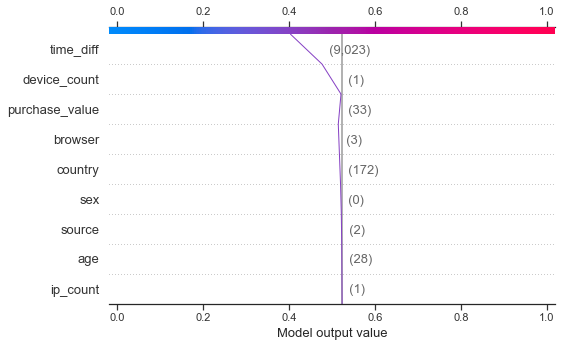

In [244]:
# Explain prediction of 1st entry in the test data
sample_idx = 1

shap.decision_plot(base_value=shap_explainer_rf.expected_value[1],  shap_values=shap_values_rf[sample_idx],
                    features=X_test.iloc[sample_idx], feature_names=X_test.columns.tolist(), link='logit', show=True,)


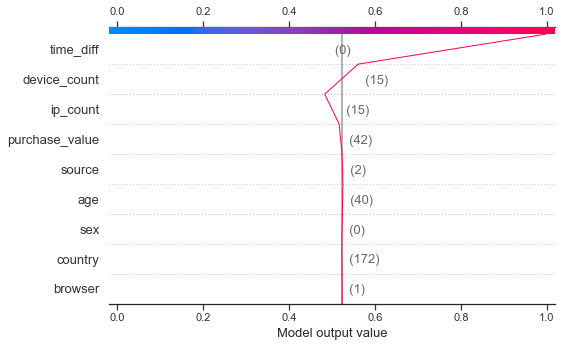

In [245]:
# Explain prediction of 6511 entry in the test data
sample_idx = 6511

shap.decision_plot(base_value=shap_explainer_rf.expected_value[1],  shap_values=shap_values_rf[sample_idx],
                    features=X_test.iloc[sample_idx], feature_names=X_test.columns.tolist(), link='logit', show=True,)

